# C elegans Motion Sequence Plotter

Running this notebook will required a installation of the [vnl-playground](https://github.com/talmolab/vnl-playground) repository. You can install it via 

```bash
pip install git+https://github.com/talmolab/vnl-playground.git
```
This notebook is used to plot some of the simple behavioral sequences in several task. Specifically, we will use this notebook to plot out the trajectory sequence from the motion capture, and plot out from the track-mjx output to illustrate the performance of the task.

In [1]:
%load_ext autoreload
%autoreload 2

# Set up environment variables before importing any graphics-related modules
import os
import sys

# Add the parent directory to the system path to import local modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Configure XLA and JAX settings
xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Configure rendering backend - use osmesa for headless rendering
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
# Remove PYOPENGL_PLATFORM to let PyOpenGL auto-detect
# if "PYOPENGL_PLATFORM" in os.environ:
#     del os.environ["PYOPENGL_PLATFORM"]

# Now import the graphics-related modules
from vnl_mjx.tasks.celegans import visualize as visualize_env
import mujoco as mj
import mujoco
import mediapy as media
import imageio
import jax
from jax import numpy as jp
import numpy as np

# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

def render(model, data=None, height: int = 400, camera: int | str = -1, filename="render.png", save=False):
    if data is None:
        data = mj.MjData(model)
    # visual mujoco rendering
    scene_option = mujoco.MjvOption()
    # scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
    # scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    # scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
    scene_option.flags[mujoco.mjtRndFlag.mjRND_SHADOW] = False
    with mj.Renderer(model, 2160, 3840) as renderer:
        mj.mj_forward(model, data)
        renderer.update_scene(data, camera=camera, scene_option=scene_option)
        frame = renderer.render()
        media.show_image(frame, height=height)
        if save:
            imageio.imwrite(filename, frame)

### environment creation

add your agents here, manipulate their names, positions.

In [2]:
# create three render environments for the rodents, ghost rodents, and both
env_imitator = visualize_env.CelegansRender()
env_reference = visualize_env.CelegansRender()
env_all = visualize_env.CelegansRender()

# ghost_rgba = (0.29, 0.62, 0.408, 0.2)
ghost_rgba = (0.6, 0.6, 0.6, 0.4)
player_rgba = (0.788, 0.4, 0.827, 0.8)
# player_rgba = (0.153, 0.537, 0.62, 0.8)

offset_per_actor = 1


# add rodents and ghost rodents to the environments
num_actors = 1
for i in range(num_actors):
    env_imitator.add_worm(
        True, pos=(0, offset_per_actor * i, 0), suffix=f"-worm-{i}", dim=2
    )

# Add sparse grid lighting for imitator environment - covering larger area
env_imitator._spec.worldbody.add_light(
    pos=(0, 0, 3), dir=(0, 0, -1), diffuse=(0.4, 0.4, 0.4)
)  # high overhead center
env_imitator._spec.worldbody.add_light(
    pos=(1.5, 0, 2), dir=(-1, 0, -1), diffuse=(0.35, 0.35, 0.35)
)  # far front overhead
env_imitator._spec.worldbody.add_light(
    pos=(-1.5, 0, 2), dir=(1, 0, -1), diffuse=(0.35, 0.35, 0.35)
)  # far back overhead
env_imitator._spec.worldbody.add_light(
    pos=(0, 1.5, 1.5), dir=(0, -1, -1), diffuse=(0.25, 0.25, 0.25)
)  # far side light
env_imitator._spec.worldbody.add_light(
    pos=(0, -1.5, 1.5), dir=(0, 1, -1), diffuse=(0.25, 0.25, 0.25)
)  # far opposite side light
env_imitator.compile()

for i in range(num_actors):
    env_reference.add_ghost(
        pos=(0.2, offset_per_actor * i, 0),
        suffix=f"-ghost-{i}",
        dim=2,
        # ghost_rgba=ghost_rgba,
    )

# Add sparse grid lighting for reference environment - covering larger area
# env_reference._spec.worldbody.add_light(
#     pos=(0.2, 0, 3), dir=(0, 0, -1), diffuse=(0.4, 0.4, 0.4)
# )  # high overhead center
# env_reference._spec.worldbody.add_light(
#     pos=(1.7, 0, 2), dir=(-1, 0, -1), diffuse=(0.35, 0.35, 0.35)
# )  # far front overhead
env_reference._spec.worldbody.add_light(
    pos=(-1.3, 0, 2), dir=(1, 0, -1), diffuse=(0.35, 0.35, 0.35)
)  # far back overhead
env_reference._spec.worldbody.add_light(
    pos=(0.2, 1.5, 1.5), dir=(0, -1, -1), diffuse=(0.25, 0.25, 0.25)
)  # far side light
env_reference._spec.worldbody.add_light(
    pos=(0.2, -1.5, 1.5), dir=(0, 1, -1), diffuse=(0.25, 0.25, 0.25)
)  # far opposite side light
env_reference.compile()

for i in range(num_actors):
    env_all.add_ghost(
        pos=(0, 0, 0),
        suffix=f"-ghost-{i}",
        dim=2,
        ghost_rgba=ghost_rgba,
    )
for i in range(num_actors):
    env_all.add_worm(
        True,
        pos=(0, 0, 0),
        suffix=f"-worm-{i}",
        dim=2,
    )

# # Add sparse grid lighting for combined environment - covering much larger area
# env_all._spec.worldbody.add_light(
#     pos=(0.1, 0, 3.5), dir=(0, 0, -1), diffuse=(0.45, 0.45, 0.45)
# )  # main high overhead
env_all._spec.worldbody.add_light(
    pos=(2, 0, 2.5), dir=(-1, 0, -1), diffuse=(0.3, 0.3, 0.3)
)  # far front right
env_all._spec.worldbody.add_light(
    pos=(-1.8, 0, 2.5), dir=(1, 0, -1), diffuse=(0.3, 0.3, 0.3)
)  # far back left
env_all._spec.worldbody.add_light(
    pos=(0.1, 2, 2), dir=(0, -1, -1), diffuse=(0.25, 0.25, 0.25)
)  # far right side
env_all._spec.worldbody.add_light(
    pos=(0.1, -2, 2), dir=(0, 1, -1), diffuse=(0.25, 0.25, 0.25)
)  # far left side
# env_all._spec.worldbody.add_light(
#     pos=(1, 1, 2), dir=(-1, -1, -1), diffuse=(0.2, 0.2, 0.2)
# )  # corner fill light
# env_all._spec.worldbody.add_light(
#     pos=(-1, -1, 2), dir=(1, 1, -1), diffuse=(0.2, 0.2, 0.2)
# )  # opposite corner fill light
env_all.compile()

Loading worm from /home/talmolab/vast/scott-yang/vnl-mjx/vnl_mjx/tasks/celegans/xmls/celegans_fast.xml
Loading ghost worm from /home/talmolab/vast/scott-yang/vnl-mjx/vnl_mjx/tasks/celegans/xmls/celegans_fast.xml
Loading ghost worm from /home/talmolab/vast/scott-yang/vnl-mjx/vnl_mjx/tasks/celegans/xmls/celegans_fast.xml
Loading worm from /home/talmolab/vast/scott-yang/vnl-mjx/vnl_mjx/tasks/celegans/xmls/celegans_fast.xml


""

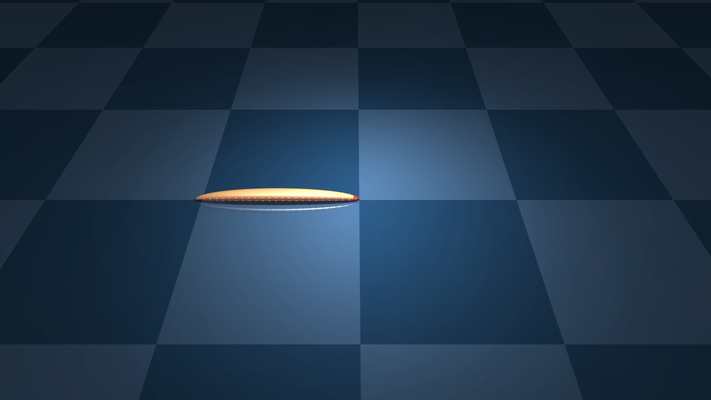

""

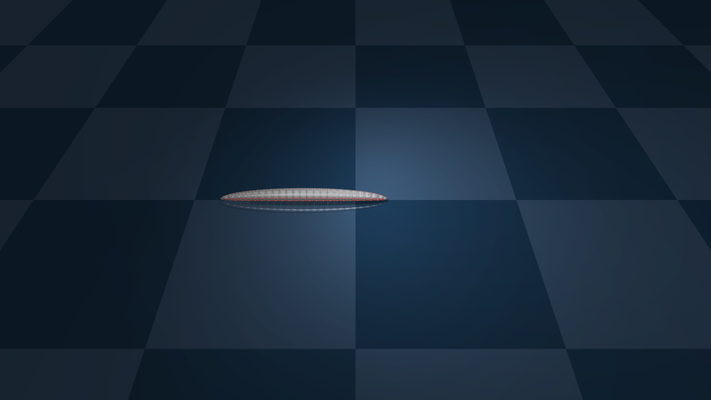

""

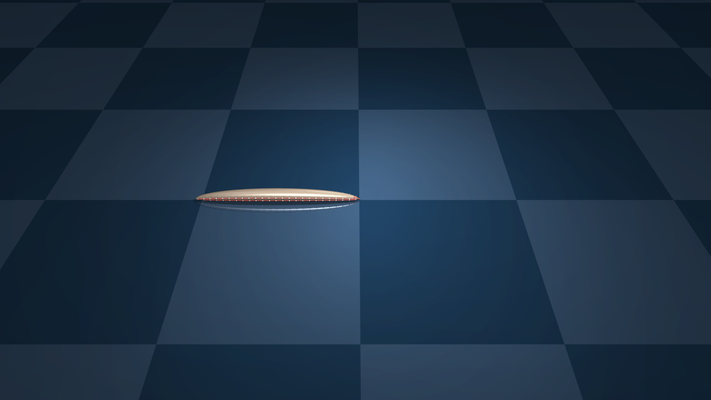

In [3]:
# take a look at the army of actors
render(env_imitator.mj_model, save=False, filename="./figures/fig4/five_flies.png")
render(env_reference.mj_model)
render(env_all.mj_model)

In [ ]:
from track_mjx.analysis.utils import load_from_h5py

qposes = load_from_h5py("celegans_locomotion_rollout.h5")

# take a look at the rollout data shape.
# each dimension will correspond to
# (number_clips, clip_length, qpose_dim)
qposes_rollout = jp.array(qposes["qposes_rollout"])
qposes_ref = jp.array(qposes["qposes_ref"])
qposes_rollout.shape, qposes_ref.shape

((126, 28), (126, 28))

In [16]:
qposes["qposes_ref"]

array([[ 0.02949981, -0.02692305, -0.02316515, ..., -0.17385137,
        -0.12986234, -0.06146932],
       [ 0.01595617, -0.02331231, -0.02313638, ..., -0.21094157,
        -0.16895847, -0.08784065],
       [ 0.00597408, -0.00727101, -0.02310575, ..., -0.20841916,
        -0.17804062, -0.09787221],
       ...,
       [ 0.7555524 ,  1.2677716 , -0.02316218, ...,  0.09469155,
         0.14167958,  0.17237844],
       [ 0.7475643 ,  1.288779  , -0.02320194, ...,  0.06344385,
         0.11341958,  0.16060013],
       [ 0.7380206 ,  1.3056887 , -0.02325004, ...,  0.03889042,
         0.0958529 ,  0.15339805]], dtype=float32)

In [17]:
# configure the desired clip to visualize
clip_id, start_idx, stride = -1, 20, 30

# index out the desired clip and stride
qposes_rollout_selected = qposes_rollout[
    start_idx : start_idx + stride * num_actors : stride, :
]
qposes_ref_selected = qposes_ref[
    start_idx : start_idx + stride * num_actors : stride, :
]

# First add the spacing offset to the x position of the rodents and ghost rodents
qposes_rollout_selected = qposes_rollout_selected.at[:, 0].set(
    qposes_rollout_selected[:, 0] + jp.arange(num_actors) * 0.3
)
qposes_ref_selected = qposes_ref_selected.at[:, 0].set(
    qposes_ref_selected[:, 0] + jp.arange(num_actors) * 0.3
)

# Now center the first two dimensions (x, y) around zero for both rollout and reference
# Calculate the mean position for centering after spacing
rollout_mean_x = jp.mean(qposes_rollout_selected[:, 0])
rollout_mean_y = jp.mean(qposes_rollout_selected[:, 1])
ref_mean_x = jp.mean(qposes_ref_selected[:, 0])
ref_mean_y = jp.mean(qposes_ref_selected[:, 1])

# Center the positions
qposes_rollout_selected = qposes_rollout_selected.at[:, 0].set(
    qposes_rollout_selected[:, 0] - rollout_mean_x
)
qposes_rollout_selected = qposes_rollout_selected.at[:, 1].set(
    qposes_rollout_selected[:, 1] - rollout_mean_y
)
qposes_ref_selected = qposes_ref_selected.at[:, 0].set(
    qposes_ref_selected[:, 0] - ref_mean_x
)
qposes_ref_selected = qposes_ref_selected.at[:, 1].set(
    qposes_ref_selected[:, 1] - ref_mean_y
)

# Flatten for final use
qposes_rollout_selected = qposes_rollout_selected.flatten()
qposes_ref_selected = qposes_ref_selected.flatten()

In [18]:
# generate initial data for rendering
data_imitator = mj.MjData(env_imitator.mj_model)
data_reference = mj.MjData(env_reference.mj_model)
data_all = mj.MjData(env_all.mj_model)

# overwrite the qpos based on the data to visualize the correct poses sequences
data_imitator.qpos = qposes_rollout_selected
data_reference.qpos = qposes_ref_selected
data_all.qpos = jp.concatenate([qposes_rollout_selected, qposes_ref_selected], axis=0)

camera_name = "track"
render(
    env_all.mj_model,
    data_all,
    camera=f"{camera_name}-ghost-1",
    save=True,
    filename=f"./figures/fig4/celegans_track_replay{clip_id=}_{start_idx=}_{stride=}.png",
)

ValueError: The camera "track-ghost-1" does not exist.

# Celegans video

In [5]:
import mediapy as media

In [6]:
mj_model = env_imitator.mj_model
mj_data = mj.MjData(mj_model)
# Warm up kinematics and reset renderer
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=512, width=512)
frames = []
for qpos in qposes_ref:
    mj_data.qpos = qpos
    mujoco.mj_forward(mj_model, mj_data)
    renderer.update_scene(mj_data, camera="track-worm-0")
    frames.append(renderer.render())

In [7]:
fps = 20
media.show_video(frames, fps=fps)
media.write_video("videos/worm/ref_solid.mp4", frames, fps=fps)

In [8]:
mj_model = env_reference.mj_model
mj_data = mj.MjData(mj_model)
# Warm up kinematics and reset renderer
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=512, width=512)
frames = []
for qpos in jp.concatenate([qposes_ref]):
    mj_data.qpos = qpos
    mujoco.mj_forward(mj_model, mj_data)
    renderer.update_scene(mj_data, camera="track-ghost-0")
    frames.append(renderer.render())

In [9]:
fps = 20
media.show_video(frames, fps=fps)
media.write_video("videos/worm/ref_ghost.mp4", frames, fps=fps)

In [10]:
qposes_all = jp.concatenate([qposes_ref, qposes_rollout], axis=-1)
qposes_all.shape

(126, 56)

In [14]:
mj_model = env_all.mj_model
mj_data = mj.MjData(mj_model)
# Warm up kinematics and reset renderer
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=512, width=512)
frames = []
for qpos in qposes_all:
    mj_data.qpos = qpos
    mujoco.mj_forward(mj_model, mj_data)
    renderer.update_scene(mj_data, camera="track-worm-0")
    frames.append(renderer.render())

In [15]:
fps = 20
media.show_video(frames, fps=fps)
media.write_video("videos/worm/track_with_ref.mp4", frames, fps=fps)

In [18]:
mj_model = env_imitator.mj_model
mj_data = mj.MjData(mj_model)
# Warm up kinematics and reset renderer
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=512, width=512)
frames = []
for qpos in qposes_rollout:
    mj_data.qpos = qpos
    mujoco.mj_forward(mj_model, mj_data)
    renderer.update_scene(mj_data, camera="track-worm-0")
    frames.append(renderer.render())

In [19]:
fps = 20
media.show_video(frames, fps=fps)
media.write_video("videos/worm/track_only.mp4", frames, fps=fps)